In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Pre-processing Dataset

LINK DATASET : https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned

In [2]:
df = pd.read_csv("depression_dataset_reddit_cleaned.csv")
# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,clean_text,is_depression
0,doing some business study revision,0
1,so i came out of clinical depression like mont...,1
2,i think i m just a bother to everyone i m goin...,1
3,i m talking to my psych on monday and i want t...,1
4,hi something weird happened to me yesterday at...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [4]:
# Missing Value Check
df.isna().sum()

clean_text       0
is_depression    0
dtype: int64

In [5]:
sentences = df['clean_text']
labels = df['is_depression']

<AxesSubplot:title={'center':'Count (target)'}>

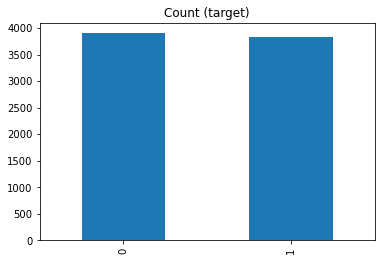

In [6]:
labels.value_counts().plot(kind='bar', title='Count (target)')

In [7]:
sentences.str.lower()

0                      doing some business study revision
1       so i came out of clinical depression like mont...
2       i think i m just a bother to everyone i m goin...
3       i m talking to my psych on monday and i want t...
4       hi something weird happened to me yesterday at...
                              ...                        
7726    i don t get it i ve know i have a future i kno...
7727    thlolo march eh it s because i don t want stre...
7728    i will say it out loud i miss you a hole and y...
7729         and so the editing of 000 wedding shot begin
7730    even when i have logical proof that it isn t t...
Name: clean_text, Length: 7731, dtype: object

In [8]:
print(sentences.str.len().max())

19822


In [9]:
word_counts = []
for i in range(df.shape[0]):
    word_count = sentences[i].count(" ") + 1
    word_counts.append(word_count)
max(word_counts)

4239

In [10]:
training_split = 0.7

### Split the Dataset

In [11]:
training_size = int(training_split * df.shape[0])
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[:training_size]
testing_labels = labels[training_size:]

### Generate Vocabulary and Padded Sequences

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
max_length = 150
vocab_size = 15000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)


## Build and Compile the Model

In [13]:
embedding_dim = 32
filters = 128
kernel_size = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
#     tf.keras.layers.MaxPool1D(pool_size=16),
    tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01),
    activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 32)           480000    
                                                                 
 conv1d (Conv1D)             (None, 146, 128)          20608     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 508,929
Trainable params: 508,929
Non-trainable params: 0
__________________________________________________

## Train the Model

In [14]:
num_epochs = 15

# Train the model
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

Epoch 1/15
170/170 - 8s - loss: 3.0629 - accuracy: 0.8194 - val_loss: 0.5543 - val_accuracy: 0.8500 - 8s/epoch - 48ms/step
Epoch 2/15
170/170 - 4s - loss: 0.4681 - accuracy: 0.8686 - val_loss: 0.4338 - val_accuracy: 0.8591 - 4s/epoch - 24ms/step
Epoch 3/15
170/170 - 4s - loss: 0.3864 - accuracy: 0.8972 - val_loss: 0.3602 - val_accuracy: 0.9164 - 4s/epoch - 24ms/step
Epoch 4/15
170/170 - 5s - loss: 0.3076 - accuracy: 0.9325 - val_loss: 0.2937 - val_accuracy: 0.9284 - 5s/epoch - 28ms/step
Epoch 5/15
170/170 - 4s - loss: 0.2481 - accuracy: 0.9542 - val_loss: 0.2535 - val_accuracy: 0.9440 - 4s/epoch - 25ms/step
Epoch 6/15
170/170 - 4s - loss: 0.2110 - accuracy: 0.9660 - val_loss: 0.2344 - val_accuracy: 0.9560 - 4s/epoch - 26ms/step
Epoch 7/15
170/170 - 5s - loss: 0.1864 - accuracy: 0.9714 - val_loss: 0.2171 - val_accuracy: 0.9608 - 5s/epoch - 29ms/step
Epoch 8/15
170/170 - 5s - loss: 0.1683 - accuracy: 0.9747 - val_loss: 0.2030 - val_accuracy: 0.9582 - 5s/epoch - 29ms/step
Epoch 9/15
170/1

In [15]:
model.evaluate(testing_padded, testing_labels, verbose = 0) 

[0.1767890900373459, 0.9564655423164368]

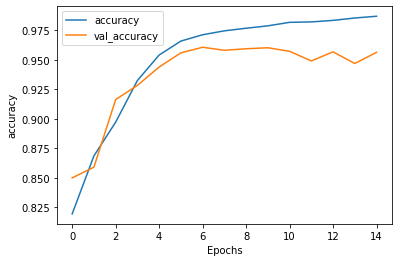

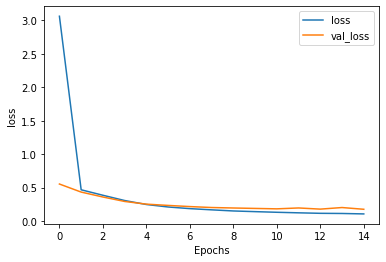

In [16]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [17]:
x_test = [
    "dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like  right guys learn math" 
    , "nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang myself"
    , "music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhymesayers willing explore new genresartists such anything generic rap the type exclusively sex drugs cool rapper is rap types pretty good pop popular couple years ago dunno technical genre name anyways anyone got music recommendations favorite artistssongs"
    , "im done trying feel betterthe reason im still alive know mum devastated ever killed myself ever passes im still state im going hesitate ending life shortly after im almost  take meds go therapy nothing seems help enough dont want around anymore hate feeling like this wouldnt wish upon enemy brain feels like constantly like static tv wont shut overthinking do think im running options dont see living past  got accepted health science degree dont even know wanna try know im smart mental illness holds back think cant anything im good enough need fucking help dont know anymore ive run options"
    , "worried  year old girl subject domestic physicalmental housewithout going lot know girl know girl etc let give brief background known girl  years lives uk live different country kept touch electronic means first girl schizophrenic host illnesses too dad severe anger issues abuses physically mentally makes serve food wash dishes clean house shouts beats petty things like spilling water picking toys floor threatened knife beats plates glasses punches head last time got beat around month ago one siblings gets beat up tried tell mother beating showed bruises too mother refuses believe even laughed off probably fear confronting him husband yells wife too family treat well either sister mean tell father put trouble family tends isolate her even remember birthday all family cold her often tend alienate since act normal girl often feels suicidal due this inflicted selfharm cut wrist starves believes way family accept her make worse two incidents life must tell about raped walking back home night initially tell parents sometime later police reports filed rape suffered false pregnancy girl symptoms disorder like lactating breasts happened early  depressed incident summer  approximately family sent couple family friends wellknown treatments advertised herbal therapy accupuncture etc however happened next terrible left alone husband wife went somewhere else guy tortured her instance made sit container filled water upto neck closed lid imagine kind stress panic would cause schizophrenic patient miscellaneous details gt gets visit psychiatrist school able hide problems psychiatrist noted girl able put front really well gt five psychiatrists past gt enjoys drawingpainting learning new languages writing poems gt depressed tends victimized mentality blames problems want report abuse due trouble family face tells stopped cutting lately problem refuses tell anyone abuse even tries defend father saying fault help her although seem extremely suicidal concern physically mental abuse girl subject everyday healthy environment anyone grow in really wish rescued clutches belligerent controlling father dysfunctional family"
    , "feel like someone needs hear tonight feeling right think cant anything people keep puting listen this its your life everyone else living it someone tells unable something work get done say wrong someone says youl never make it work hard make end one make it could make putting people like that see life nobody tell cant do one tell live where love look end let climb height hope someone needed hear tonight beutiful life good night sincerely  austin zippy"
    , "one best episodes entire xfiles series creepy beyond words tension suspense episode well executed entire  minutes managed almost scary entire movie episode joins ranks best episodes greats home humbug bad blood milagro best respective seasonbr br mulder scullys growing relationship put test episode really trust other episode also contains tiny scene leave romantic viewers smilingbr br mulder bring mittens"
]

x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
y_pred = model.predict(x_test_pad)

1/1 [==============================] - 0s 289ms/step


In [18]:
print(y_pred)

[[0.01975183]
 [0.36808813]
 [0.02906301]
 [0.9999781 ]
 [0.968594  ]
 [0.9994197 ]
 [0.02821283]]


In [19]:
model.save('depression_detection_model.h5')

In [20]:
from keras.models import model_from_json

json_model = model.to_json()
with open('depression_detection_model.json', 'w') as json_file:
    json_file.write(json_model)
    
model.save_weights('depression_detection_weights.h5')